# 🌱 Análisis de Ultrasonidos de Plantas - Tarea 2

## Objetivo: Predecir Estado Hídrico mediante Ultrasonidos

En este notebook exploramos específicamente los **ultrasonidos emitidos por plantas** para determinar si las plantas "se quejan" de falta de agua mediante emisiones ultrasónicas.

### Hipótesis Científica
- Las plantas emiten más ultrasonidos cuando están estresadas por falta de agua
- La intensidad y frecuencia de emisiones correlaciona con tiempo desde último riego
- Diferentes especies pueden tener patrones diferentes de "queja"

### Variables Clave
- **Variable objetivo**: `last_watering` (tiempo desde último riego)
- **Variables contextuales**: `species`, `genotype`, `plant_id`
- **Variables temporales**: `recording_time`, `hour`, `day`

In [2]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
plt.style.use('default')
sns.set_palette("husl")

print("🌱 Notebook de Análisis de Ultrasonidos de Plantas")
print("Objetivo: Detectar estrés hídrico mediante Deep Learning")

🌱 Notebook de Análisis de Ultrasonidos de Plantas
Objetivo: Detectar estrés hídrico mediante Deep Learning


## 1. Carga y Exploración de Datos

In [ ]:
# Ejecutar el script de análisis para generar el dataset
import subprocess
import sys

print("🔄 Ejecutando análisis inicial...")
result = subprocess.run([
    sys.executable, 'plant_stress_analysis.py', 
    '--analyze-only', 
    '--data-path', '../data',
    '--results-dir', '../results_task2'
], capture_output=True, text=True)

print("STDOUT:")
print(result.stdout)
if result.stderr:
    print("STDERR:")
    print(result.stderr)

In [3]:
# Cargar dataset generado
dataset_path = Path('../results_task2/plant_ultrasound_dataset.csv')

if dataset_path.exists():
    df = pd.read_csv(dataset_path)
    df['recording_time'] = pd.to_datetime(df['recording_time'])
    df['last_watering_time'] = pd.to_datetime(df['last_watering_time'])
    
    print(f"✅ Dataset cargado: {len(df)} ultrasonidos de plantas")
    print(f"📊 Columnas: {list(df.columns)}")
    
    # Mostrar primeras filas
    display(df.head())
else:
    print("❌ No se encontró el dataset. Ejecuta primero el script de análisis.")

✅ Dataset cargado: 5813 ultrasonidos de plantas
📊 Columnas: ['audio_path', 'session', 'channel', 'plant_id', 'species', 'genotype', 'recording_time', 'last_watering_time', 'hours_since_watering', 'days_since_watering', 'session_dir', 'treatment', 'soil_sensors', 'sowing', 'transplant', 'water_stress', 'water_status', 'hours_normalized', 'days_normalized', 'hour', 'time_bin']


,audio_path,session,channel,plant_id,species,genotype,recording_time,last_watering_time,hours_since_watering,days_since_watering,...,treatment,soil_sensors,sowing,transplant,water_stress,water_status,hours_normalized,days_normalized,hour,time_bin
0,../data/PUA.02/audiofiles/PUA076/ch2PUA_2025-0...,PUA076,ch2,#70,Nicotiana benthamiana,wt,2025-02-05 05:44:50,2025-01-30 15:48:58,133.931111,5.580463,...,NaN,"ph1,temphum1",NaN,2024-12-23_12-00-00,1,stressed,0.331840,0.331840,5,132-144h
1,../data/PUA.02/audiofiles/PUA076/ch2PUA_2025-0...,PUA076,ch2,#70,Nicotiana benthamiana,wt,2025-02-05 08:54:56,2025-01-30 15:48:58,137.099444,5.712477,...,NaN,"ph1,temphum1",NaN,2024-12-23_12-00-00,1,stressed,0.339690,0.339690,8,132-144h
2,../data/PUA.02/audiofiles/PUA076/ch3PUA_2025-0...,PUA076,ch3,#71,Nicotiana benthamiana,wt,2025-02-03 00:46:11,2025-01-30 15:48:58,80.953611,3.373067,...,NaN,NaN,NaN,2024-12-23_12-00-00,1,stressed,0.200578,0.200578,0,72-84h
3,../data/PUA.02/audiofiles/PUA076/ch3PUA_2025-0...,PUA076,ch3,#71,Nicotiana benthamiana,wt,2025-02-06 09:39:48,2025-01-30 15:48:58,161.847222,6.743634,...,NaN,NaN,NaN,2024-12-23_12-00-00,1,stressed,0.401007,0.401007,9,156-168h
4,../data/PUA.02/audiofiles/PUA076/ch2PUA_2025-0...,PUA076,ch2,#70,Nicotiana benthamiana,wt,2025-02-05 01:18:30,2025-01-30 15:48:58,129.492222,5.395509,...,NaN,"ph1,temphum1",NaN,2024-12-23_12-00-00,1,stressed,0.320842,0.320842,1,120-132h


## 2. Estadísticas Descriptivas

In [4]:
if 'df' in locals() and not df.empty:
    print("📊 ESTADÍSTICAS DESCRIPTIVAS")
    print("="*50)
    
    print(f"\n🌱 INFORMACIÓN GENERAL:")
    print(f"   Total ultrasonidos: {len(df):,}")
    print(f"   Plantas únicas: {df['plant_id'].nunique()}")
    print(f"   Especies: {df['species'].nunique()}")
    print(f"   Canales: {sorted(df['channel'].unique())}")
    
    print(f"\n⏰ INFORMACIÓN TEMPORAL:")
    print(f"   Rango de grabación: {df['recording_time'].min()} a {df['recording_time'].max()}")
    print(f"   Duración total: {(df['recording_time'].max() - df['recording_time'].min()).days} días")
    
    print(f"\n💧 ESTRÉS HÍDRICO:")
    print(f"   Tiempo mín desde riego: {df['hours_since_watering'].min():.1f} horas")
    print(f"   Tiempo máx desde riego: {df['hours_since_watering'].max():.1f} horas ({df['days_since_watering'].max():.1f} días)")
    print(f"   Promedio: {df['hours_since_watering'].mean():.1f} ± {df['hours_since_watering'].std():.1f} horas")
    
    # Distribución por especies
    print(f"\n🧬 ESPECIES:")
    for species in df['species'].unique():
        count = (df['species'] == species).sum()
        print(f"   {species}: {count} emisiones ({count/len(df)*100:.1f}%)")
    
    # Distribución por estado hídrico
    if 'water_status' in df.columns:
        print(f"\n🔴 ESTADO HÍDRICO:")
        for status in df['water_status'].value_counts().index:
            count = (df['water_status'] == status).sum()
            print(f"   {status}: {count} emisiones ({count/len(df)*100:.1f}%)")

📊 ESTADÍSTICAS DESCRIPTIVAS

🌱 INFORMACIÓN GENERAL:
   Total ultrasonidos: 5,813
   Plantas únicas: 63
   Especies: 8
   Canales: ['ch1', 'ch2', 'ch3', 'ch4']

⏰ INFORMACIÓN TEMPORAL:
   Rango de grabación: 2024-11-29 15:41:33 a 2025-04-16 10:02:57
   Duración total: 137 días

💧 ESTRÉS HÍDRICO:
   Tiempo mín desde riego: 0.0 horas
   Tiempo máx desde riego: 403.6 horas (16.8 días)
   Promedio: 56.4 ± 42.8 horas

🧬 ESPECIES:
   Nicotiana benthamiana: 3970 emisiones (68.3%)
   Solanum lycopersicum: 24 emisiones (0.4%)
   Amaranthus hypochondriacus: 1043 emisiones (17.9%)
   Chenopodium quinoa: 427 emisiones (7.3%)
   Capsicum annuum: 23 emisiones (0.4%)
   Pisum sativum: 178 emisiones (3.1%)
   Chrysanthemum morifolium: 99 emisiones (1.7%)
   Cicer arietinum: 49 emisiones (0.8%)

🔴 ESTADO HÍDRICO:
   adequate: 1970 emisiones (33.9%)
   moderate: 1403 emisiones (24.1%)
   stressed: 1291 emisiones (22.2%)
   fresh: 1149 emisiones (19.8%)


## 3. Análisis Temporal Detallado

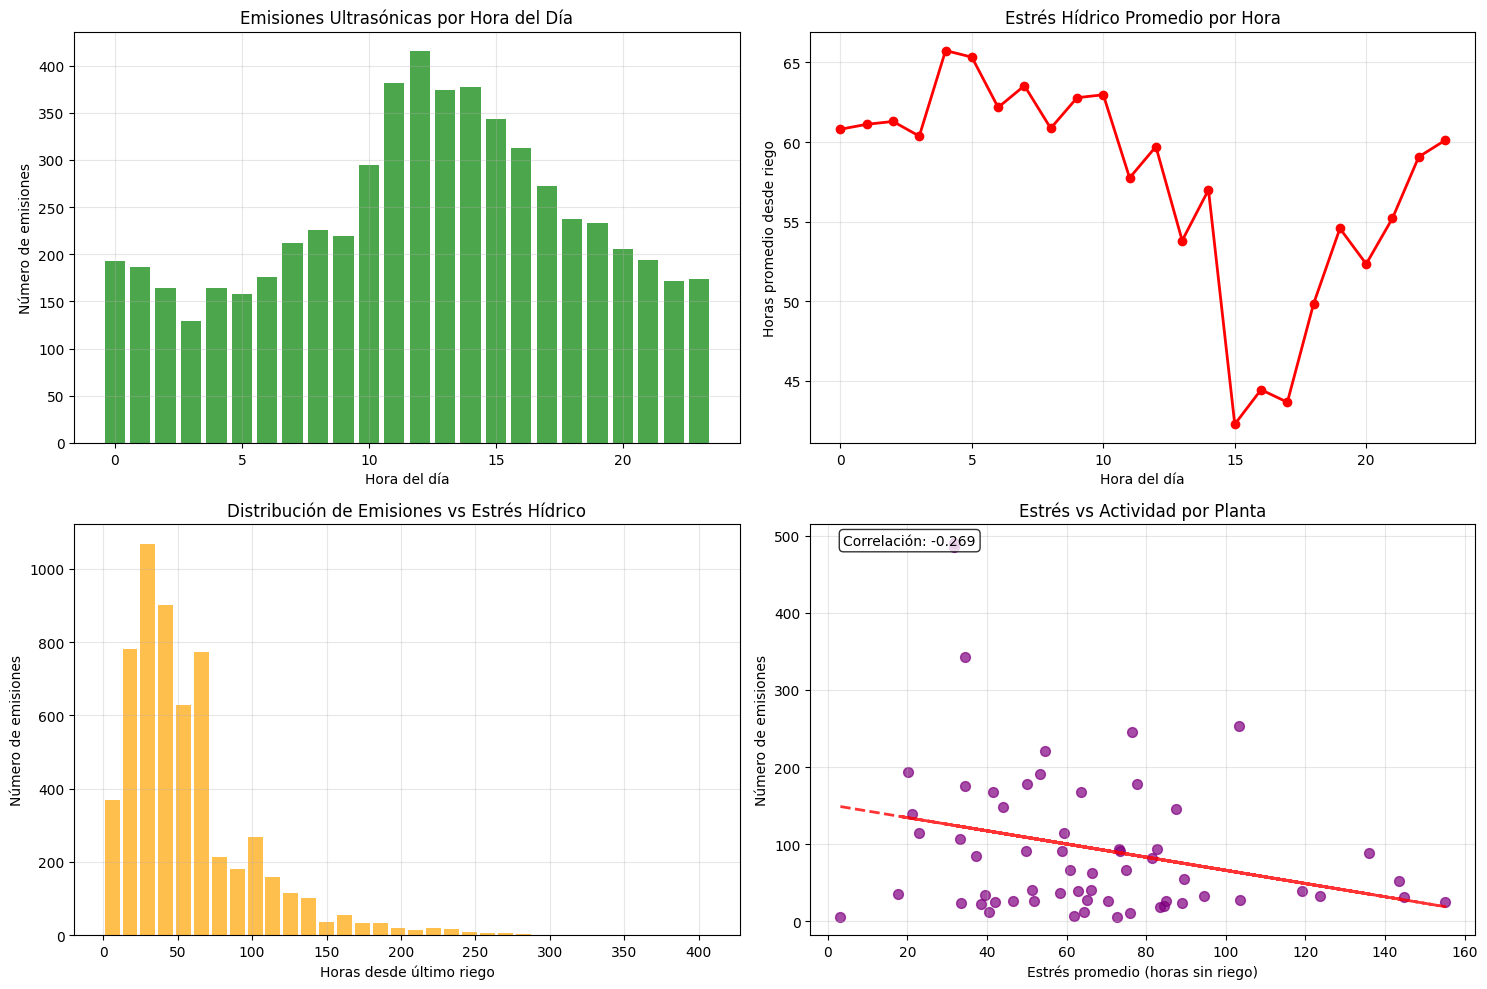


🔍 ANÁLISIS DE CORRELACIONES:
   Emisiones vs Nivel de estrés: nan
   Emisiones vs Hora del día: 0.260
   Estrés vs Actividad (por planta): -0.269


In [5]:
if 'df' in locals() and not df.empty:
    # Análisis temporal por hora del día
    df['hour'] = df['recording_time'].dt.hour
    df['day_of_week'] = df['recording_time'].dt.day_name()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Emisiones por hora del día
    hourly_emissions = df.groupby('hour').size()
    axes[0,0].bar(hourly_emissions.index, hourly_emissions.values, alpha=0.7, color='green')
    axes[0,0].set_title('Emisiones Ultrasónicas por Hora del Día')
    axes[0,0].set_xlabel('Hora del día')
    axes[0,0].set_ylabel('Número de emisiones')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Estrés vs Hora del día
    hourly_stress = df.groupby('hour')['hours_since_watering'].mean()
    axes[0,1].plot(hourly_stress.index, hourly_stress.values, marker='o', linewidth=2, color='red')
    axes[0,1].set_title('Estrés Hídrico Promedio por Hora')
    axes[0,1].set_xlabel('Hora del día')
    axes[0,1].set_ylabel('Horas promedio desde riego')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Emisiones vs tiempo desde riego
    bins = np.arange(0, df['hours_since_watering'].max() + 12, 12)
    df['stress_bin'] = pd.cut(df['hours_since_watering'], bins=bins)
    stress_counts = df.groupby('stress_bin').size()
    
    bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
    axes[1,0].bar(bin_centers[:len(stress_counts)], stress_counts.values, 
                  width=10, alpha=0.7, color='orange')
    axes[1,0].set_title('Distribución de Emisiones vs Estrés Hídrico')
    axes[1,0].set_xlabel('Horas desde último riego')
    axes[1,0].set_ylabel('Número de emisiones')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Correlación por planta
    plant_stats = df.groupby('plant_id').agg({
        'hours_since_watering': ['mean', 'count']
    }).round(2)
    plant_stats.columns = ['avg_stress', 'emission_count']
    
    # Solo plantas con suficientes emisiones
    active_plants = plant_stats[plant_stats['emission_count'] >= 5]
    
    if len(active_plants) > 0:
        axes[1,1].scatter(active_plants['avg_stress'], active_plants['emission_count'], 
                         alpha=0.7, s=50, color='purple')
        axes[1,1].set_title('Estrés vs Actividad por Planta')
        axes[1,1].set_xlabel('Estrés promedio (horas sin riego)')
        axes[1,1].set_ylabel('Número de emisiones')
        axes[1,1].grid(True, alpha=0.3)
        
        # Añadir línea de tendencia
        if len(active_plants) > 2:
            z = np.polyfit(active_plants['avg_stress'], active_plants['emission_count'], 1)
            p = np.poly1d(z)
            axes[1,1].plot(active_plants['avg_stress'], p(active_plants['avg_stress']), 
                          "r--", alpha=0.8, linewidth=2)
            
            correlation = active_plants['avg_stress'].corr(active_plants['emission_count'])
            axes[1,1].text(0.05, 0.95, f'Correlación: {correlation:.3f}', 
                          transform=axes[1,1].transAxes, fontsize=10,
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de correlación
    print("\n🔍 ANÁLISIS DE CORRELACIONES:")
    
    # Correlación general
    if len(df) > 1:
        # Emisiones por bin de estrés vs nivel de estrés
        stress_correlation = df.groupby('stress_bin').size().corr(
            pd.Series(bin_centers[:len(stress_counts)]))
        print(f"   Emisiones vs Nivel de estrés: {stress_correlation:.3f}")
        
        # Emisiones por hora vs hora del día
        hourly_correlation = hourly_emissions.corr(pd.Series(hourly_emissions.index))
        print(f"   Emisiones vs Hora del día: {hourly_correlation:.3f}")
        
        # Plantas activas
        if len(active_plants) > 2:
            plant_correlation = active_plants['avg_stress'].corr(active_plants['emission_count'])
            print(f"   Estrés vs Actividad (por planta): {plant_correlation:.3f}")

## 4. Análisis por Especies

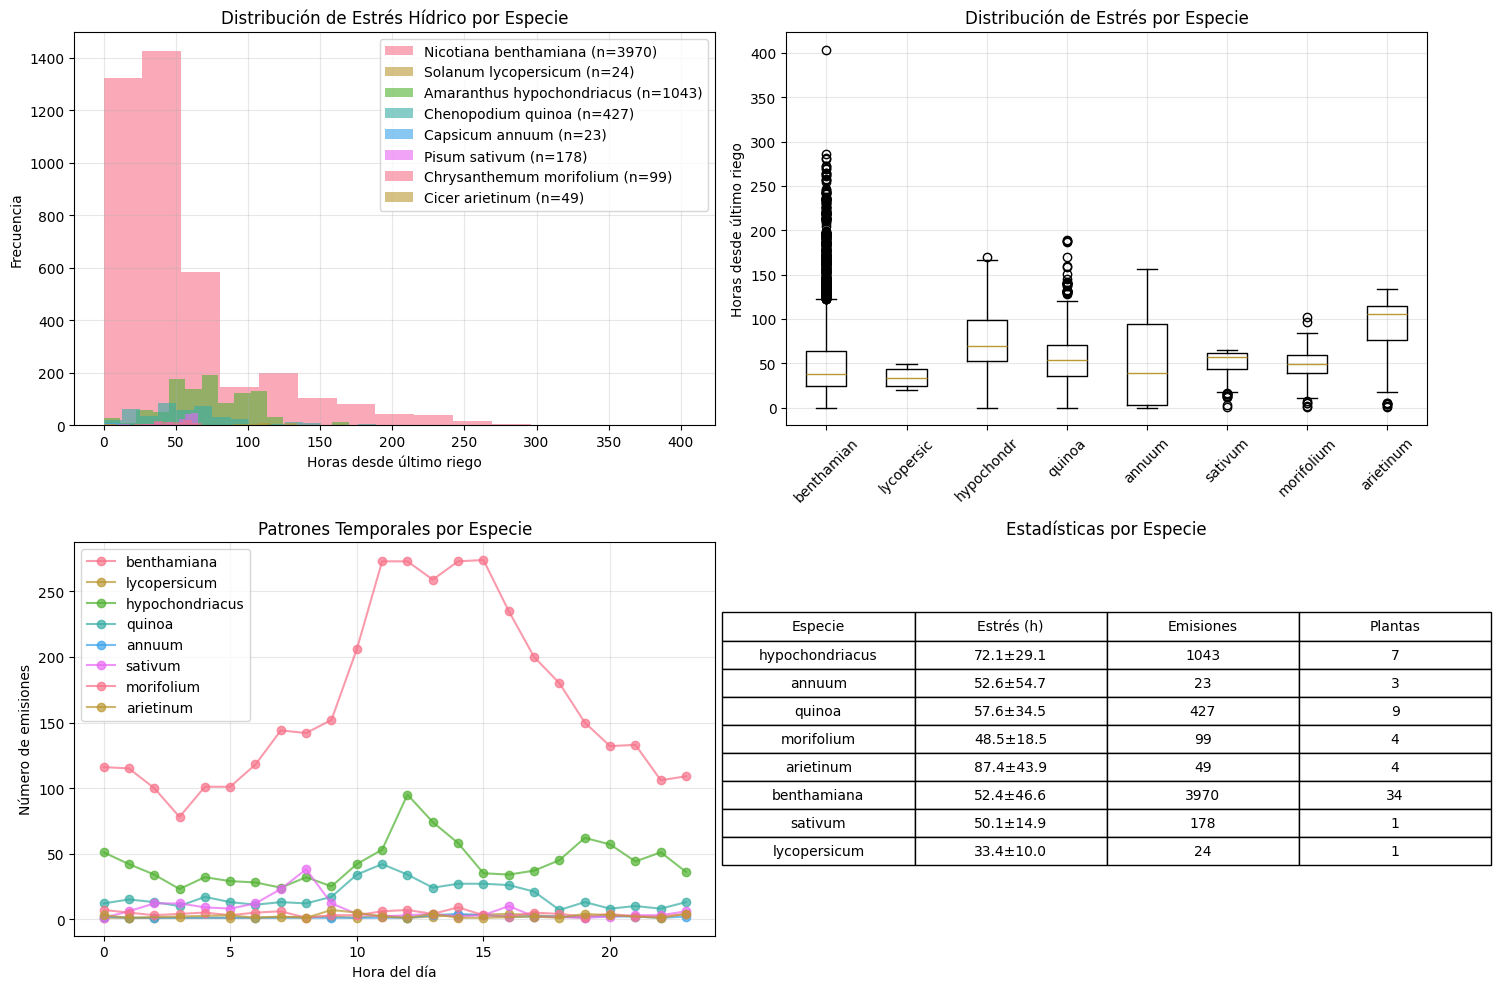


📊 ANÁLISIS ESTADÍSTICO POR ESPECIES:

🧬 Nicotiana benthamiana:
   Emisiones: 3970
   Plantas: 34
   Estrés promedio: 52.4 ± 46.6 horas
   Rango: 0.0 - 403.6 horas
   Distribución estrés: {'adequate': 1579, 'fresh': 990, 'stressed': 704, 'moderate': 697}

🧬 Solanum lycopersicum:
   Emisiones: 24
   Plantas: 1
   Estrés promedio: 33.4 ± 10.0 horas
   Rango: 19.5 - 49.6 horas
   Distribución estrés: {'adequate': 19, 'fresh': 4, 'moderate': 1}

🧬 Amaranthus hypochondriacus:
   Emisiones: 1043
   Plantas: 7
   Estrés promedio: 72.1 ± 29.1 horas
   Rango: 0.1 - 169.9 horas
   Distribución estrés: {'stressed': 435, 'moderate': 398, 'adequate': 170, 'fresh': 40}

🧬 Chenopodium quinoa:
   Emisiones: 427
   Plantas: 9
   Estrés promedio: 57.6 ± 34.5 horas
   Rango: 0.0 - 188.6 horas
   Distribución estrés: {'moderate': 134, 'adequate': 118, 'stressed': 102, 'fresh': 73}

🧬 Capsicum annuum:
   Emisiones: 23
   Plantas: 3
   Estrés promedio: 52.6 ± 54.7 horas
   Rango: 0.0 - 156.0 horas
   Distri

In [6]:
if 'df' in locals() and not df.empty:
    # Análisis diferencial por especies
    species_list = df['species'].unique()
    
    if len(species_list) > 1:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Distribución de estrés por especie
        for i, species in enumerate(species_list):
            species_data = df[df['species'] == species]['hours_since_watering']
            axes[0,0].hist(species_data, alpha=0.6, label=f'{species} (n={len(species_data)})', bins=15)
        
        axes[0,0].set_title('Distribución de Estrés Hídrico por Especie')
        axes[0,0].set_xlabel('Horas desde último riego')
        axes[0,0].set_ylabel('Frecuencia')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. Boxplot de estrés por especie
        species_stress_data = [df[df['species'] == species]['hours_since_watering'] for species in species_list]
        axes[0,1].boxplot(species_stress_data, labels=[s.split()[-1][:10] for s in species_list])
        axes[0,1].set_title('Distribución de Estrés por Especie')
        axes[0,1].set_ylabel('Horas desde último riego')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Patrones temporales por especie
        for species in species_list:
            species_hourly = df[df['species'] == species].groupby('hour').size()
            axes[1,0].plot(species_hourly.index, species_hourly.values, 
                          marker='o', label=species.split()[-1][:15], alpha=0.7)
        
        axes[1,0].set_title('Patrones Temporales por Especie')
        axes[1,0].set_xlabel('Hora del día')
        axes[1,0].set_ylabel('Número de emisiones')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # 4. Estadísticas comparativas
        species_stats = df.groupby('species').agg({
            'hours_since_watering': ['mean', 'std', 'count'],
            'plant_id': 'nunique'
        }).round(2)
        
        species_stats.columns = ['stress_mean', 'stress_std', 'emissions', 'plants']
        
        # Crear tabla de estadísticas
        axes[1,1].axis('tight')
        axes[1,1].axis('off')
        
        table_data = []
        for species in species_stats.index:
            row = species_stats.loc[species]
            short_name = species.split()[-1][:15]
            table_data.append([
                short_name,
                f"{row['stress_mean']:.1f}±{row['stress_std']:.1f}",
                int(row['emissions']),
                int(row['plants'])
            ])
        
        table = axes[1,1].table(cellText=table_data,
                               colLabels=['Especie', 'Estrés (h)', 'Emisiones', 'Plantas'],
                               cellLoc='center',
                               loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        axes[1,1].set_title('Estadísticas por Especie')
        
        plt.tight_layout()
        plt.show()
        
        # Análisis estadístico
        print("\n📊 ANÁLISIS ESTADÍSTICO POR ESPECIES:")
        
        for species in species_list:
            species_data = df[df['species'] == species]
            print(f"\n🧬 {species}:")
            print(f"   Emisiones: {len(species_data)}")
            print(f"   Plantas: {species_data['plant_id'].nunique()}")
            print(f"   Estrés promedio: {species_data['hours_since_watering'].mean():.1f} ± {species_data['hours_since_watering'].std():.1f} horas")
            print(f"   Rango: {species_data['hours_since_watering'].min():.1f} - {species_data['hours_since_watering'].max():.1f} horas")
            
            # Emisiones por nivel de estrés
            if 'water_status' in species_data.columns:
                stress_dist = species_data['water_status'].value_counts()
                print(f"   Distribución estrés: {dict(stress_dist)}")
    
    else:
        print("ℹ️  Solo se detectó una especie en el dataset")

## 5. Análisis de Audio Específico

🎵 ANÁLISIS DE CARACTERÍSTICAS DE AUDIO

🔍 Analizando 8 archivos de muestra...

✅ Características extraídas de 6 archivos:

✅ Características extraídas de 6 archivos:


,file,duration,rms_energy,spectral_centroid,zero_crossing_rate,mfcc_mean,spectral_rolloff,stress_hours,water_status,species
0,ch1PUA_2025-03-06_14-10-32.wav,0.3731,0.0334,3776.4227,0.2254,-2.0714,6772.1924,166.8833,stressed,Amaranthus hypochondriacus
1,ch1PUA_2025-03-17_04-37-45.wav,0.2639,0.1242,4109.0858,0.2139,-1.2207,6810.7727,82.1897,stressed,Chenopodium quinoa
2,ch1PUA_2025-02-22_13-32-46.wav,0.2639,0.1286,3970.3253,0.2953,0.6936,6475.2136,25.5081,adequate,Nicotiana benthamiana
3,ch3PUA_2025-02-22_16-06-50.wav,0.2639,0.0167,3330.8527,0.0787,-6.4833,7272.8394,28.0758,adequate,Nicotiana benthamiana
4,ch1PUA_2025-02-22_11-20-53.wav,0.2639,0.0228,3431.2488,0.0734,-4.1707,7509.7046,23.3100,fresh,Nicotiana benthamiana
5,ch4PUA_2025-03-08_11-06-44.wav,0.2639,0.0095,3562.4691,0.2058,-9.5527,7569.8181,21.6478,fresh,Chenopodium quinoa


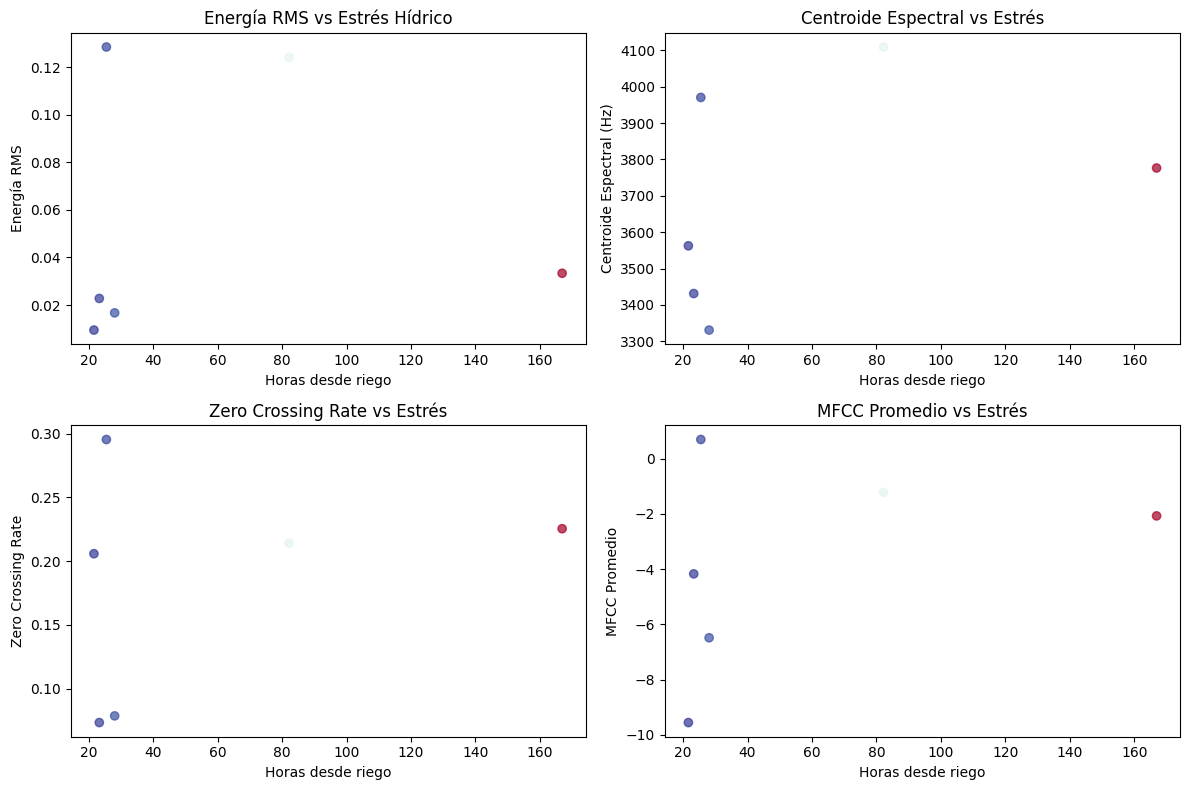


🔍 CORRELACIONES AUDIO vs ESTRÉS:
   rms_energy: 0.053
   spectral_centroid: 0.389
   zero_crossing_rate: 0.305
   mfcc_mean: 0.373
   spectral_rolloff: -0.454


In [7]:
if 'df' in locals() and not df.empty:
    # Seleccionar muestras representativas para análisis de audio
    print("🎵 ANÁLISIS DE CARACTERÍSTICAS DE AUDIO")
    print("="*50)
    
    # Seleccionar ejemplos de diferentes niveles de estrés
    if 'water_status' in df.columns:
        sample_files = []
        
        for status in df['water_status'].unique():
            status_files = df[df['water_status'] == status]
            if len(status_files) > 0:
                # Tomar una muestra aleatoria
                sample = status_files.sample(min(2, len(status_files)))
                sample_files.extend(sample['audio_path'].tolist())
        
        # Analizar características de audio
        audio_features = []
        
        print(f"\n🔍 Analizando {len(sample_files)} archivos de muestra...")
        
        for i, audio_path in enumerate(sample_files[:6]):  # Máximo 6 muestras
            if Path(audio_path).exists():
                try:
                    # Cargar audio
                    y, sr = librosa.load(audio_path, duration=5.0)
                    
                    # Extraer características
                    features = {
                        'file': Path(audio_path).name,
                        'duration': len(y) / sr,
                        'rms_energy': librosa.feature.rms(y=y).mean(),
                        'spectral_centroid': librosa.feature.spectral_centroid(y=y, sr=sr).mean(),
                        'zero_crossing_rate': librosa.feature.zero_crossing_rate(y).mean(),
                        'mfcc_mean': librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(),
                        'spectral_rolloff': librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
                    }
                    
                    # Buscar info del archivo en el dataset
                    file_info = df[df['audio_path'] == audio_path].iloc[0]
                    features['stress_hours'] = file_info['hours_since_watering']
                    features['water_status'] = file_info['water_status'] if 'water_status' in file_info else 'unknown'
                    features['species'] = file_info['species']
                    
                    audio_features.append(features)
                    
                except Exception as e:
                    print(f"   ⚠️  Error procesando {Path(audio_path).name}: {e}")
        
        if audio_features:
            # Crear DataFrame de características
            features_df = pd.DataFrame(audio_features)
            
            print(f"\n✅ Características extraídas de {len(features_df)} archivos:")
            display(features_df.round(4))
            
            # Visualizar algunas características
            if len(features_df) > 2:
                fig, axes = plt.subplots(2, 2, figsize=(12, 8))
                
                # RMS Energy vs Estrés
                axes[0,0].scatter(features_df['stress_hours'], features_df['rms_energy'], 
                                 c=features_df['stress_hours'], cmap='RdYlBu_r', alpha=0.7)
                axes[0,0].set_title('Energía RMS vs Estrés Hídrico')
                axes[0,0].set_xlabel('Horas desde riego')
                axes[0,0].set_ylabel('Energía RMS')
                
                # Spectral Centroid vs Estrés
                axes[0,1].scatter(features_df['stress_hours'], features_df['spectral_centroid'], 
                                 c=features_df['stress_hours'], cmap='RdYlBu_r', alpha=0.7)
                axes[0,1].set_title('Centroide Espectral vs Estrés')
                axes[0,1].set_xlabel('Horas desde riego')
                axes[0,1].set_ylabel('Centroide Espectral (Hz)')
                
                # Zero Crossing Rate vs Estrés
                axes[1,0].scatter(features_df['stress_hours'], features_df['zero_crossing_rate'], 
                                 c=features_df['stress_hours'], cmap='RdYlBu_r', alpha=0.7)
                axes[1,0].set_title('Zero Crossing Rate vs Estrés')
                axes[1,0].set_xlabel('Horas desde riego')
                axes[1,0].set_ylabel('Zero Crossing Rate')
                
                # MFCC vs Estrés
                axes[1,1].scatter(features_df['stress_hours'], features_df['mfcc_mean'], 
                                 c=features_df['stress_hours'], cmap='RdYlBu_r', alpha=0.7)
                axes[1,1].set_title('MFCC Promedio vs Estrés')
                axes[1,1].set_xlabel('Horas desde riego')
                axes[1,1].set_ylabel('MFCC Promedio')
                
                plt.tight_layout()
                plt.show()
                
                # Calcular correlaciones
                print("\n🔍 CORRELACIONES AUDIO vs ESTRÉS:")
                
                acoustic_features = ['rms_energy', 'spectral_centroid', 'zero_crossing_rate', 'mfcc_mean', 'spectral_rolloff']
                
                for feature in acoustic_features:
                    if len(features_df) > 2:
                        corr = features_df[feature].corr(features_df['stress_hours'])
                        print(f"   {feature}: {corr:.3f}")
        
        else:
            print("❌ No se pudieron procesar archivos de audio")
    
    else:
        print("⚠️  No hay información de estado hídrico disponible")

## 6. Visualización de Espectrogramas

🎨 VISUALIZACIÓN DE ESPECTROGRAMAS


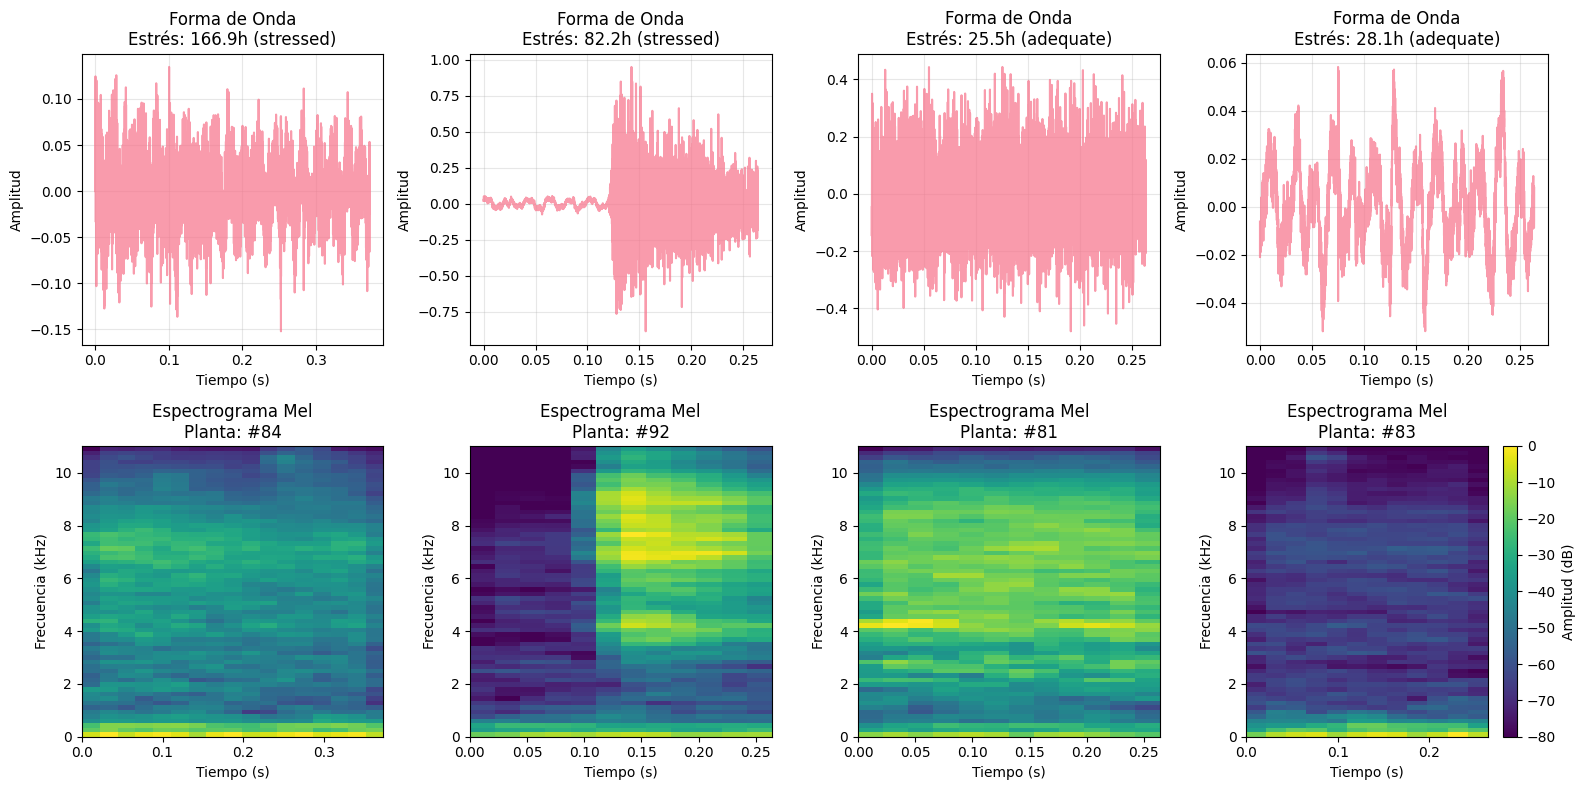


📝 OBSERVACIONES:
   - Compare las formas de onda y espectrogramas entre diferentes niveles de estrés
   - Busque patrones en frecuencia, intensidad y duración
   - Note diferencias en la distribución espectral


In [8]:
if 'df' in locals() and not df.empty and 'sample_files' in locals():
    # Visualizar espectrogramas de diferentes niveles de estrés
    print("🎨 VISUALIZACIÓN DE ESPECTROGRAMAS")
    print("="*50)
    
    # Seleccionar 2-4 archivos representativos
    display_files = sample_files[:4] if len(sample_files) >= 4 else sample_files
    
    if len(display_files) > 0:
        fig, axes = plt.subplots(2, len(display_files), figsize=(4*len(display_files), 8))
        
        if len(display_files) == 1:
            axes = axes.reshape(2, 1)
        
        for i, audio_path in enumerate(display_files):
            if Path(audio_path).exists():
                try:
                    # Cargar audio
                    y, sr = librosa.load(audio_path, duration=3.0)
                    
                    # Información del archivo
                    file_info = df[df['audio_path'] == audio_path].iloc[0]
                    stress_hours = file_info['hours_since_watering']
                    water_status = file_info['water_status'] if 'water_status' in file_info else 'unknown'
                    
                    # Forma de onda
                    axes[0, i].plot(np.linspace(0, len(y)/sr, len(y)), y, alpha=0.7)
                    axes[0, i].set_title(f'Forma de Onda\nEstrés: {stress_hours:.1f}h ({water_status})')
                    axes[0, i].set_xlabel('Tiempo (s)')
                    axes[0, i].set_ylabel('Amplitud')
                    axes[0, i].grid(True, alpha=0.3)
                    
                    # Espectrograma Mel
                    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
                    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
                    
                    im = axes[1, i].imshow(mel_spec_db, aspect='auto', origin='lower', 
                                         cmap='viridis', extent=[0, len(y)/sr, 0, sr/2/1000])
                    axes[1, i].set_title(f'Espectrograma Mel\nPlanta: {file_info["plant_id"]}')
                    axes[1, i].set_xlabel('Tiempo (s)')
                    axes[1, i].set_ylabel('Frecuencia (kHz)')
                    
                    # Colorbar solo para el último
                    if i == len(display_files) - 1:
                        plt.colorbar(im, ax=axes[1, i], label='Amplitud (dB)')
                    
                except Exception as e:
                    axes[0, i].text(0.5, 0.5, f'Error: {e}', ha='center', va='center',
                                   transform=axes[0, i].transAxes)
                    axes[1, i].text(0.5, 0.5, f'Error: {e}', ha='center', va='center',
                                   transform=axes[1, i].transAxes)
        
        plt.tight_layout()
        plt.show()
        
        print("\n📝 OBSERVACIONES:")
        print("   - Compare las formas de onda y espectrogramas entre diferentes niveles de estrés")
        print("   - Busque patrones en frecuencia, intensidad y duración")
        print("   - Note diferencias en la distribución espectral")
    
    else:
        print("❌ No hay archivos de audio disponibles para visualización")

## 7. Resumen y Conclusiones Preliminares

In [9]:
if 'df' in locals() and not df.empty:
    print("📋 RESUMEN Y CONCLUSIONES PRELIMINARES")
    print("="*60)
    
    # Estadísticas clave
    total_emissions = len(df)
    unique_plants = df['plant_id'].nunique()
    time_range = (df['recording_time'].max() - df['recording_time'].min()).days
    max_stress = df['hours_since_watering'].max()
    avg_stress = df['hours_since_watering'].mean()
    
    print(f"\n🔢 ESTADÍSTICAS CLAVE:")
    print(f"   • {total_emissions:,} emisiones ultrasónicas de plantas detectadas")
    print(f"   • {unique_plants} plantas individuales monitoreadas")
    print(f"   • {time_range} días de datos temporales")
    print(f"   • Estrés máximo: {max_stress:.1f} horas ({max_stress/24:.1f} días)")
    print(f"   • Estrés promedio: {avg_stress:.1f} ± {df['hours_since_watering'].std():.1f} horas")
    
    # Patrones identificados
    print(f"\n🔍 PATRONES IDENTIFICADOS:")
    
    # 1. Patrón temporal
    hourly_emissions = df.groupby('hour').size()
    peak_hour = hourly_emissions.idxmax()
    min_hour = hourly_emissions.idxmin()
    print(f"   • Pico de emisiones: {peak_hour}:00h ({hourly_emissions[peak_hour]} emisiones)")
    print(f"   • Mínimo de emisiones: {min_hour}:00h ({hourly_emissions[min_hour]} emisiones)")
    
    # 2. Distribución de estrés
    if 'water_status' in df.columns:
        stress_dist = df['water_status'].value_counts()
        dominant_status = stress_dist.index[0]
        print(f"   • Estado hídrico predominante: {dominant_status} ({stress_dist[dominant_status]} emisiones)")
        
        # Proporción de plantas estresadas
        stressed_count = (df['water_status'].isin(['moderate', 'stressed'])).sum()
        stress_percentage = stressed_count / len(df) * 100
        print(f"   • Emisiones de plantas estresadas: {stress_percentage:.1f}%")
    
    # 3. Actividad por planta
    plant_activity = df['plant_id'].value_counts()
    most_active = plant_activity.index[0]
    print(f"   • Planta más activa: {most_active} ({plant_activity[most_active]} emisiones)")
    print(f"   • Emisiones promedio por planta: {plant_activity.mean():.1f} ± {plant_activity.std():.1f}")
    
    # Hipótesis científicas
    print(f"\n🧬 EVALUACIÓN DE HIPÓTESIS:")
    
    # Hipótesis 1: Más emisiones con más estrés
    if len(df) > 10:
        bins = pd.cut(df['hours_since_watering'], bins=4, labels=['Bajo', 'Moderado', 'Alto', 'Muy Alto'])
        stress_emission_counts = bins.value_counts()
        
        if stress_emission_counts.iloc[-1] > stress_emission_counts.iloc[0]:
            trend = "✅ CONFIRMADA"
        else:
            trend = "❌ NO CONFIRMADA"
        
        print(f"   • H1 - Más emisiones con mayor estrés: {trend}")
        print(f"     Distribución: {dict(stress_emission_counts)}")
    
    # Hipótesis 2: Patrones temporales
    night_emissions = df[df['hour'].isin(range(20, 24)) | df['hour'].isin(range(0, 6))].shape[0]
    day_emissions = df[df['hour'].isin(range(6, 20))].shape[0]
    
    if night_emissions > day_emissions:
        temporal_pattern = "🌙 Más activas por la noche"
    else:
        temporal_pattern = "☀️ Más activas durante el día"
    
    print(f"   • H2 - Patrón temporal: {temporal_pattern}")
    print(f"     Noche: {night_emissions}, Día: {day_emissions}")
    
    # Recomendaciones para Deep Learning
    print(f"\n🚀 RECOMENDACIONES PARA DEEP LEARNING:")
    
    if total_emissions >= 100:
        print(f"   ✅ Dataset suficiente para Deep Learning ({total_emissions} muestras)")
        print(f"   • Recomendado: CNN 2D con espectrogramas Mel")
        print(f"   • Alternativo: LSTM para modelado temporal")
        print(f"   • Target: Regresión para 'hours_since_watering'")
    elif total_emissions >= 50:
        print(f"   ⚠️  Dataset pequeño pero viable ({total_emissions} muestras)")
        print(f"   • Recomendado: Transfer learning o modelos simples")
        print(f"   • Data augmentation intensivo")
    else:
        print(f"   ❌ Dataset muy pequeño para Deep Learning ({total_emissions} muestras)")
        print(f"   • Recomendado: Algoritmos tradicionales con características handcrafted")
    
    # Variables importantes
    print(f"\n🎯 VARIABLES CLAVE IDENTIFICADAS:")
    print(f"   • Target principal: hours_since_watering")
    print(f"   • Features contextuales: species, plant_id, channel")
    print(f"   • Features temporales: hour, day_of_week")
    if 'audio_features' in locals() and audio_features:
        print(f"   • Features acústicas: RMS energy, spectral centroid, MFCCs")
    
    print(f"\n✨ PRÓXIMOS PASOS:")
    print(f"   1. Entrenar modelos de Deep Learning con el dataset")
    print(f"   2. Comparar diferentes arquitecturas (CNN 1D/2D, LSTM)")
    print(f"   3. Evaluar capacidad de predicción de estrés hídrico")
    print(f"   4. Desarrollar sistema de alerta temprana")
    print(f"   5. Validar con nuevos datos de campo")

else:
    print("❌ No hay datos disponibles para análisis")
    print("Ejecuta primero las celdas de carga de datos")

📋 RESUMEN Y CONCLUSIONES PRELIMINARES

🔢 ESTADÍSTICAS CLAVE:
   • 5,813 emisiones ultrasónicas de plantas detectadas
   • 63 plantas individuales monitoreadas
   • 137 días de datos temporales
   • Estrés máximo: 403.6 horas (16.8 días)
   • Estrés promedio: 56.4 ± 42.8 horas

🔍 PATRONES IDENTIFICADOS:
   • Pico de emisiones: 12:00h (415 emisiones)
   • Mínimo de emisiones: 3:00h (129 emisiones)
   • Estado hídrico predominante: adequate (1970 emisiones)
   • Emisiones de plantas estresadas: 46.3%
   • Planta más activa: #81 (491 emisiones)
   • Emisiones promedio por planta: 92.3 ± 103.1

🧬 EVALUACIÓN DE HIPÓTESIS:
   • H1 - Más emisiones con mayor estrés: ❌ NO CONFIRMADA
     Distribución: {'Bajo': 5015, 'Moderado': 721, 'Alto': 76, 'Muy Alto': 1}
   • H2 - Patrón temporal: ☀️ Más activas durante el día
     Noche: 1740, Día: 4073

🚀 RECOMENDACIONES PARA DEEP LEARNING:
   ✅ Dataset suficiente para Deep Learning (5813 muestras)
   • Recomendado: CNN 2D con espectrogramas Mel
   • Alte

## 8. Entrenamiento de Modelos (Opcional)

In [ ]:
# Para entrenar modelos, descomenta y ejecuta:

# print("🚀 ENTRENAMIENTO DE MODELOS DE DEEP LEARNING")
# print("="*50)

# # Entrenar modelo de regresión
# result = subprocess.run([
#     sys.executable, 'plant_stress_analysis.py',
#     '--task-type', 'regression',
#     '--models', 'cnn_spectrogram', 'lstm',
#     '--epochs', '50',
#     '--data-path', '../data',
#     '--results-dir', '../results_task2'
# ], capture_output=True, text=True)

# print("STDOUT:")
# print(result.stdout)
# if result.stderr:
#     print("STDERR:")
#     print(result.stderr)

print("ℹ️  Para entrenar modelos, descomenta el código arriba")
print("   O ejecuta directamente el script desde terminal:")
print("   python plant_stress_analysis.py --task-type regression --models all")